In [1]:
# 导入环境的包
import time
import sys
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt  # this is used for the plot the graph
import seaborn as sns  # used for plot interactive graph.
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters

## keras
from tcn import TCN
from tensorflow.keras.layers import Dense,Dropout,LSTM,GRU
from tensorflow.keras.models import Sequential

In [2]:
# config matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 30, 10
register_matplotlib_converters()

In [3]:
#将序列转为监督学习序列数据
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
daily_cases_ = pd.read_csv('../new_daily_cases/new_daily_cases_China.csv').iloc[:,1:]
df_resample=daily_cases_.T
df_resample

,0
1/23/20,0.0
1/24/20,0.0
1/25/20,0.0
1/26/20,0.0
1/27/20,0.0
...,...
5/10/22,7895.0
5/11/22,7357.0
5/12/22,7118.0
5/13/22,6768.0


In [5]:
## * Note: 归一化数据范围为0-1.

values = df_resample.values 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# 数据转为监督学习数据，time-step=1
reframed = series_to_supervised(scaled, 1, 1)

In [6]:
# 划分数据集
values = reframed.values
#https://easy-station.taobao.com/
#一般训练数据集以总数据的*0.7，测试数据以总数据的*0.3，
train = values[400:-7, :]
test = values[-7:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# 构建数据的3D 格式，即[samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
test_y

(435, 1, 1) (435,) (7, 1, 1) (7,)


array([0.18285159, 0.17188859, 0.15969174, 0.14880964, 0.1439754 ,
       0.13689597, 0.1255082 ])

In [7]:
time_start = time.time()  # 记录开始时间

#网络模型
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=8, validation_data=(test_X, test_y), verbose=2, shuffle=False)

time_end = time.time()  # 记录结束时间
time_sum = time_end - time_start  # 计算的时间差为程序的执行时间，单位为秒/s
print("train time:",time_sum)


# 显示训练的loss值情况
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss in LSTM')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
# plt.show()

time_start = time.time()  # 记录开始时间

# 做预测
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 1))
# i反归一化预测值
inv_yhat = np.concatenate((yhat, test_X[:,:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# 反归一化真实值
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:,:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

time_end = time.time()  # 记录结束时间
time_sum = time_end - time_start  # 计算的时间差为程序的执行时间，单位为秒/s
print("predict time:",time_sum)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.4f' % rmse)

Epoch 1/100
55/55 - 2s - loss: 0.0177 - val_loss: 0.0179
Epoch 2/100
55/55 - 0s - loss: 0.0157 - val_loss: 0.0133
Epoch 3/100
55/55 - 0s - loss: 0.0150 - val_loss: 0.0113
Epoch 4/100
55/55 - 0s - loss: 0.0145 - val_loss: 0.0100
Epoch 5/100
55/55 - 0s - loss: 0.0137 - val_loss: 0.0091
Epoch 6/100
55/55 - 0s - loss: 0.0128 - val_loss: 0.0082
Epoch 7/100
55/55 - 0s - loss: 0.0121 - val_loss: 0.0072
Epoch 8/100
55/55 - 0s - loss: 0.0112 - val_loss: 0.0063
Epoch 9/100
55/55 - 0s - loss: 0.0098 - val_loss: 0.0053
Epoch 10/100
55/55 - 0s - loss: 0.0087 - val_loss: 0.0043
Epoch 11/100
55/55 - 0s - loss: 0.0078 - val_loss: 0.0034
Epoch 12/100
55/55 - 0s - loss: 0.0067 - val_loss: 0.0025
Epoch 13/100
55/55 - 0s - loss: 0.0063 - val_loss: 0.0019
Epoch 14/100
55/55 - 0s - loss: 0.0056 - val_loss: 0.0014
Epoch 15/100
55/55 - 0s - loss: 0.0046 - val_loss: 9.5036e-04
Epoch 16/100
55/55 - 0s - loss: 0.0049 - val_loss: 7.3552e-04
Epoch 17/100
55/55 - 0s - loss: 0.0048 - val_loss: 6.0043e-04
Epoch 18/10

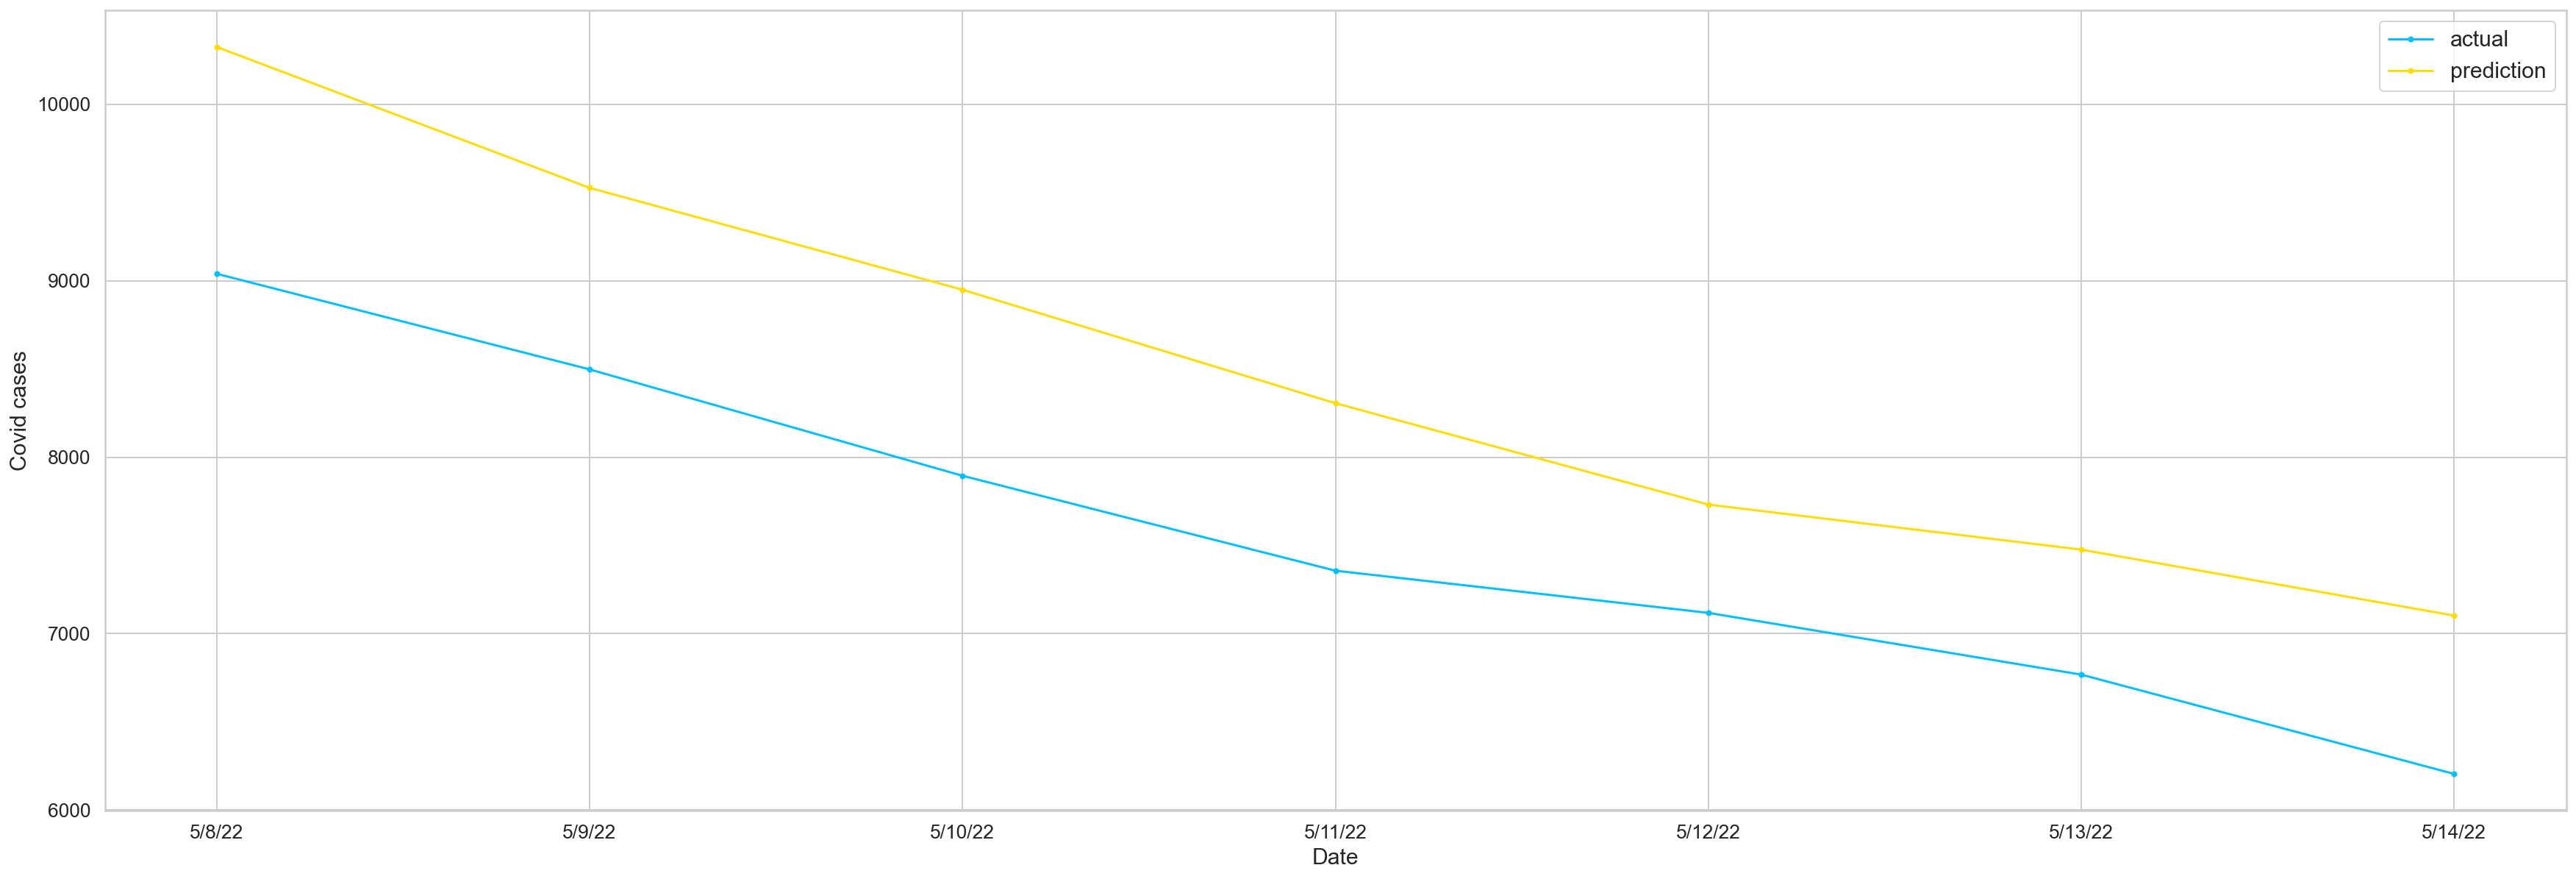

In [9]:
# 显示预测结果
plt.plot(df_resample.index[-7:], inv_y[-7:], marker='.', label="actual")
plt.plot(df_resample.index[-7:], inv_yhat[:],  marker='.',label="prediction")
plt.ylabel('Covid cases', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=15)
plt.show()

In [10]:
true_cases=inv_y
predicted_cases=inv_yhat
predicted_cases.astype(int)

array([10325,  9527,  8949,  8306,  7731,  7476,  7102])

In [11]:

# MSE = np.linalg.norm(true_cases-predicted_cases, ord=2)**2/len(true_cases)

RMSE = np.linalg.norm(true_cases-predicted_cases, ord=2)/len(true_cases)**0.5

NRMSE=RMSE/(np.max(true_cases)-np.min(true_cases))

# MAE = np.linalg.norm(true_cases-predicted_cases, ord=1)/len(true_cases)

MAPE=100 * np.mean(np.abs(true_cases-predicted_cases)) / np.mean(true_cases) 

SMAPE=200 * np.mean(np.abs(true_cases-predicted_cases) / (np.abs(true_cases) + np.abs(predicted_cases))) 


RMSE = round(RMSE,4)

NRMSE = round(NRMSE,4)

MAPE = round(MAPE,4)

SMAPE = round(SMAPE,4)

summary=[RMSE,NRMSE,MAPE,SMAPE]

summary

[956.782, 0.3375, 12.3629, 11.576]

In [12]:
history.history['loss']

[0.017666075378656387,
 0.01573745347559452,
 0.015013318508863449,
 0.014497253112494946,
 0.01372620277106762,
 0.012831541709601879,
 0.012126734480261803,
 0.011161529459059238,
 0.009772306308150291,
 0.008722495287656784,
 0.007766608614474535,
 0.006717117503285408,
 0.006324631627649069,
 0.005613614339381456,
 0.004636204801499844,
 0.004934809170663357,
 0.0047733960673213005,
 0.005044298246502876,
 0.0039032557979226112,
 0.0046728854067623615,
 0.0035558734089136124,
 0.004859101492911577,
 0.0044718412682414055,
 0.004207286983728409,
 0.005164369009435177,
 0.00445706769824028,
 0.004515476990491152,
 0.0042487322352826595,
 0.004554458428174257,
 0.004859460983425379,
 0.003939829301089048,
 0.004353777039796114,
 0.004191367421299219,
 0.004720066674053669,
 0.004550613928586245,
 0.004610634408891201,
 0.004427279811352491,
 0.004107280634343624,
 0.004219453781843185,
 0.0030562765896320343,
 0.004804601892828941,
 0.003510295646265149,
 0.003260588739067316,
 0.0034

In [13]:
history.history['val_loss']

[0.017866211012005806,
 0.013288314454257488,
 0.011275308206677437,
 0.010035141371190548,
 0.009089963510632515,
 0.008151776157319546,
 0.007231435272842646,
 0.00627113739028573,
 0.005283269565552473,
 0.004303834866732359,
 0.003405357478186488,
 0.002508157165721059,
 0.0018914018291980028,
 0.0013880288461223245,
 0.000950358749832958,
 0.0007355152629315853,
 0.0006004255847074091,
 0.0005005308776162565,
 0.0003171743010170758,
 0.00033529303618706763,
 0.00014585691678803414,
 0.00020809131092391908,
 0.00015905815234873444,
 0.000183601732715033,
 0.0002391527668805793,
 0.00020689326629508287,
 0.00014723710773978382,
 0.0001994445192394778,
 9.638727351557463e-05,
 0.00021178644965402782,
 0.00011403927783248946,
 0.00020004702673759311,
 0.00010546558041824028,
 0.00011955486115766689,
 0.0001013162182061933,
 8.672546391608194e-05,
 8.15738967503421e-05,
 8.745176455704495e-05,
 5.184609835851006e-05,
 1.0743836355686653e-05,
 5.2236162446206436e-05,
 5.487548150995281e